# Step5 演習03 教師強制
---

本演習では、教師強制のモデルを実装します。ここではある入力文字列から次の文字を予測してみます。

**はじめに**
- for文やwhile文の利用は明示的な利用指示がない場所での利用は避けてください。

**本演習の目的**
- RNNにおける教師強制モデルの実装

## タスクについて

この演習では教師強制のモデルを使って1つ前の文字から次の文字を予測します。例えば、"今日はいい天気です”という文章がある時、入力が"天"の場合出力が"気"となるように学習させます。通常、教師強制は機械翻訳やイメージキャプショニング（入力が画像で出力がその画像を説明する文章）などのタスクに使われますが、このようなモデルの学習は時間がかかり演習としては不向きなので、今回は単純な単語予測に教師強制を使用します。１つだけこの演習を始める前に理解していただきたいのは、教師強制のモデルでは学習時は**1つ前の単語の情報しか**与えられていません。なので先程の"今日はいい天気です”の例ですと、モデルは1つ目の"い"が入力の時は"い"と予測し、2つ目の"い"が入力の時は"天"と予測しなければならず、このモデルはこの文章を生成するのは不可能となります。なので、**これから実装していただく単語予測はそもそもタスクとしては適切ではありません。**

繰り返しになりますが、学習時間の削減をし、教師強制の計算の理解を深めていただくことを目標にこの演習を用意しました。

## ライブラリのインストール

まずはじめに、本演習で利用するライブラリのインポートを行います。

- [numpy](http://www.numpy.org) 数値計算を行うための基本パッケージの公式ドキュメント
- [matplotlib](http://matplotlib.org) グラフ描画ライブラリの基本パッケージの公式ドキュメント

`%matplotlib inline` はnotebook上で使える[magic function](http://ipython.readthedocs.io/en/stable/interactive/magics.html)の一つで、これによりmatplotlibをインタラクティブに使うことできます。

In [1]:
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt

## データセット

これまではMNISTを使ってきましたが、ここではwikipediaからもってきた文章を使います。文章に簡単な修正を加えて、開始シグナルとして"#"、終了シグナルとして"*"を追加しています。

RNNで文字を扱う際は直接文字を予測することはできないので、まず文字を例えば、A=1, B=2, C=3のように数値化しなければなりません。さらにニューラルネットワークで扱いやすいようにone-hotベクトル化しなければなりません。（例：A=[001], B=[010], C=[100])ここでは数値化する際に必要な辞書（`char2ix`）と、逆に数値化したものからもとの文字に戻す際に必要な辞書（`ix2char`）を作成準備します。

In [2]:
# sample.txtというファイルからリードモード（r)でテキストを読み込む
text = open('./dataset/step5_sample.txt', 'r').read()
# テキスト内で使用されている文字を取得
chars = list(set(text))
data_size, num_chars = len(text), len(chars)
print('テキスト： {}字\n使用されている文字: {}字'.format(data_size, num_chars))
print('----\n{}\n----'.format(chars))
# 文字列->数値/数値->文字列に変換する際に必要な辞書を作成
char2ix = {ch:i for i,ch in enumerate(chars)}
ix2char = {i:ch for i,ch in enumerate(chars)}
seq_length = 24
print('\n----入力文章\n{}\n----'.format(text))

テキスト： 312字
使用されている文字: 138字
----
['、', '結', '以', '術', '高', '所', '向', '機', 'e', 'タ', '普', 'デ', 'ら', 'プ', '発', 'ッ', 'と', '上', 'ン', 'ト', '#', '理', '圧', '層', '達', '適', '1', '械', 'あ', '倒', 'を', 'も', '言', '近', '音', '充', '化', 'ラ', '習', 'ヒ', 'そ', 'ワ', 'さ', '計', 'う', 'す', 'れ', '0', '2', 'し', 'ィ', '・', '最', '研', '。', 'や', '登', '像', 'b', '多', 'の', '*', 'か', 'ー', 'ず', 'グ', '示', 'び', '能', 'ク', '語', '芳', '前', '果', '明', 'ん', 'せ', '局', '的', '代', '声', '練', 'が', 'ど', 'ネ', 'ル', '手', '力', '調', 'く', '因', '他', 'て', '算', '必', 'る', '勾', '題', 'ニ', '配', 'W', 'な', '画', 'に', '法', '究', '場', '消', '対', '性', 'で', 'た', 'ュ', 'い', '４', 'は', 'っ', 'お', '年', '象', '深', '問', '論', '及', '要', '進', '然', '失', '解', '容', '易', '技', '訓', 'ま', '学', '分', '自', 'よ']
----

----入力文章
#ディープラーニングまたは深層学習とは、多層のニューラルネットワークによる機械学習手法である。深層学習登場以前、４層以上の深層ニューラルネットは、局所最適解や勾配消失などの技術的な問題によって充分学習させられず、性能も芳しくなかった。しかし、近年、ヒントンらによる多層ニューラルネットワークの学習の研究や、学習に必要な計算機の能力向上、および、Webの発達による訓練データ調達の容易化によって、充分学習させられるようになった。その結果、音声・画像・自然言語を対象とする問題に対し、他の手法を圧倒する高い性能を示し、2010年

## モデルの構築

### モデルパラメータの準備

今回は下記のモデルパラメータを用います。隠れ層は128にします。

In [3]:
hidden_size = 128 # 隠れ層のサイズ
num_char = len(char2ix) # 文字の種類の数

### モデルの重みの初期化

ここでもモデルのパラメータを[glorot_uniform](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)で初期化します。バイアスはゼロで初期化します。

["glorot_uniform"](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)
$$\pm\sqrt{\frac{6}{(input\_channel+ output\_channel)}}$$

そして[Adam](https://arxiv.org/pdf/1412.6980.pdf)を使ってモデルを学習させるので、その際に必要な配列を用意します。

`init_parameters`の最後では重みのパラメータとAdamに必要なパラメータをまとめて返します。

In [4]:
def glorot_uniform(shape):
    if len(shape) == 2:
        fan_in, fan_out = shape
        std = np.sqrt(6./(fan_in+fan_out))
        return np.random.uniform(low=-std, high=std, size=(fan_in, fan_out))
    else:
        raise NotImplementedError()

In [5]:
def init_parameters(num_char, hidden_size):
    #入力から隠れ層の重み
    U = glorot_uniform((num_char, hidden_size))

    # 出力層から隠れ層の重み
    W = glorot_uniform((num_char, hidden_size)) 

    #隠れ層から出力層の重み
    V = glorot_uniform((hidden_size, num_char)) 

    # 隠れ層のバイアス
    b = np.zeros((1, hidden_size))
    # 出力層のバイアス
    c = np.zeros((1, num_char))

    # Adamを使用するにあたって必要なパラメータの初期化
    mU, mW, mV = np.zeros_like(U), np.zeros_like(W), np.zeros_like(V)
    mb, mc = np.zeros_like(b), np.zeros_like(c)
    vU, vW, vV = np.zeros_like(U), np.zeros_like(W), np.zeros_like(V)
    vb, vc = np.zeros_like(b), np.zeros_like(c)
        
    # パラメータをタプルにまとめます。
    params = (U, W, V, b, c)
    ms = (mU, mW, mV, mb, mc)
    vs = (vU, vW, vV, vb, vc)
    return params, ms, vs

### フォワードプロパゲーションの実装

通常のRNNは1ステップ前の隠れ状態を使って次の隠れ状態を計算するので、並列化ができませんでした。そこで教師強制の登場です。教師強制では、下図のように訓練時は正解ラベルyを次のステップの隠れ層へと接続します。正解ラベルyは予め全ステップにおいて分かっているので、1ステップ毎に隠れ層と出力層の計算する必要はなく、全ステップ一括で計算することができます。

<img src="./img/step5_teacher_forcing.png" width="360" height="120">

** フォワードプロパゲーション**
$$
\begin{eqnarray}
\boldsymbol{a}{(t)}&=&\boldsymbol{b}+\boldsymbol{y}{(t-1)}\boldsymbol{W}+\boldsymbol{x}{(t)}\boldsymbol{U}\\
\boldsymbol{h}{(t)}&=&tanh(\boldsymbol{a}{(t)})\\
\boldsymbol{o}{(t)}&=&\boldsymbol{c}+\boldsymbol{h}{(t)}\boldsymbol{V}\\
\boldsymbol{\hat{y}}{(t)}&=&softmax(\boldsymbol{o}{(t)})
\end{eqnarray}
$$

もう一度演習の目的を復習します。例えば文字列ABCDがあったとします。このときAをいれるとB,次にBをいれるとC、と次の文字を予測するRNNを作成します。ここで上の式をよくみてみると、$y(t-1)$は一つ前の入力なので、$x(t)$と等しくなります。また、先ほど述べたように1ステップ前の隠れ状態もいらないので、時刻$t$毎に分けて計算する必要はありません。以上を踏まえると上記の式は以下のように書き換えられます。

** フォワードプロパゲーション（学習時）**
$$
\begin{eqnarray}
\boldsymbol{a}&=&\boldsymbol{b}+\boldsymbol{x}\boldsymbol{W}+\boldsymbol{x}\boldsymbol{U}\\
\boldsymbol{h}&=&tanh(\boldsymbol{a})\\
\boldsymbol{o}&=&\boldsymbol{c}+\boldsymbol{h}\boldsymbol{V}\\
\boldsymbol{\hat{y}}&=&softmax(\boldsymbol{o})
\end{eqnarray}
$$

**【課題１】**　以上の知識を使って教師強制RNNの順伝播を実装してください。

`forward_propagation_train`3つの引数があります。
- `X`: 入力（バッチ次元、データ長=seq_length、文字数=num_chars）
- `Y`: 出力（バッチ次元、データ長=seq_length、文字数=num_chars）
- `params`: `init_parameters`で用意した重みとバイアス

上記式に従って順伝播を実装してください。`softmax`関数は予め実装してあるものを使って下さい。

そして、ここではコスト関数も順伝播の関数内で計算してしまいます。`cross_entropy_loss`も予め用意してあります。コスト関数実装後、最後に`loss`をデータ長(`seq_length`)で割るのを忘れないでください。

In [12]:
#Coursedele-02 Step5 QuestionNumber7 a3bc5548487a4d10717bd61d83cad3fd
def softmax(x, axis):
    c = np.max(x)
    exp_x = np.exp(x - c)
    y = exp_x / np.sum(exp_x, axis=axis, keepdims=True) 
    return y

def cross_entropy_loss(y, y_hat, m):
    cost = - np.sum(y * np.log(y_hat)) / m        
    return cost

def forward_propagation_train(X, Y, params):
    U, W, V, b, c = params
    batch_size, seq_length = X.shape[:2]
    
    ###############START CODE HERE###############
    a = b + np.dot(X, W) + np.dot(X, U)
    h = np.tanh(a)
    o = c + np.dot(h, V)
    # softmatxの引数のaxisは2
    Y_hat = softmax(o, 2)
    loss = cross_entropy_loss(Y, Y_hat, batch_size)
    loss /= seq_length
    ################END CODE HERE################
    return Y_hat, h, loss

** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [13]:
%%bash
./validation_client.py dele-02 5 7 Step5_03.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



** フォワードプロパゲーション（テスト時）**
$$
\begin{eqnarray}
\boldsymbol{a}{(t)}&=&\boldsymbol{b}+\boldsymbol{\hat{y}}{(t-1)}\boldsymbol{W}+\boldsymbol{x}{(t)}\boldsymbol{U}\\
\boldsymbol{h}{(t)}&=&tanh(\boldsymbol{a}{(t)})\\
\boldsymbol{o}{(t)}&=&\boldsymbol{c}+\boldsymbol{h}{(t)}\boldsymbol{V}\\
\boldsymbol{\hat{y}}{(t)}&=&softmax(\boldsymbol{o}{(t)})
\end{eqnarray}
$$

**【課題２】**　上記式に従って教師強制RNNのテスト時の順伝播を実装してください。

`forward_propagation_test`3つの引数があります。
- `X`: 入力（バッチ次元、データ長=seq_length、文字数=num_chars）
- `Y`: 出力（バッチ次元、データ長=seq_length、文字数=num_chars）
- `params`: `init_parameters`で用意した重みとバイアス

In [20]:
#Coursedele-02 Step5 QuestionNumber8 e77392fcc5084817e936dfc2f4acf958
def forward_propagation_test(X, Y, params):
    U, W, V, b, c = params
    batch_size, seq_length = X.shape[:2]
    
    # lossの初期化
    loss = 0
    # 一番初めのy(t-1)はスタートシグナルである'#'に設定
    Y_hat = {}
    eye = np.eye(len(char2ix)) 
    Y_hat[-1] = eye[char2ix['#']].reshape(1,-1)
    
    ###############START CODE HERE###############
    for t in range(seq_length):
        a = b + np.dot(Y_hat[t-1], W) + np.dot(X[:, t], U)
        h = np.tanh(a)
        o = c + np.dot(h, V)
        # softmatxの引数のaxisは1
        Y_hat[t] = softmax(o, 1)
        loss += cross_entropy_loss(Y[:, t], Y_hat[t], batch_size)
    loss /= seq_length
    ################END CODE HERE################
    return Y_hat, loss

** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [21]:
%%bash
./validation_client.py dele-02 5 8 Step5_03.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



### バックプロパゲーションの実装

教師強制RNNの逆伝播は、訓練時の順伝播の式を元に実装します。ここでは、効率的に計算するために、[np.einsum](https://docs.scipy.org/doc/numpy/reference/generated/numpy.einsum.html)を使います。詳しく知りたい方はリンク先を読むか、アインシュタインの縮約記法で検索してみて下さい。

In [22]:
def backward_propagation(params, X, h, Y_hat, Y):
    U, W, V, b, c = params
    batch_size, seq_length = X.shape[:2]

    delta_o = (np.copy(Y_hat) - Y) / batch_size / seq_length
    delta_V = np.einsum('ijk,ijl->kl', h, delta_o) 
    delta_c = np.sum(delta_o, axis=(0, 1))
    
    delta_h = np.dot(delta_o, V.T)
    delta_a = (1 - h * h) * delta_h
    delta_b = np.sum(delta_a, axis=(0, 1))
    delta_U = np.einsum('ijk,ijl->kl', X, delta_a)
    delta_W = np.einsum('ijk,ijl->kl', X, delta_a)
    
    grads = (delta_U, delta_W, delta_V, delta_b, delta_c)
    # 勾配クリッピング
    for g in grads:
        np.clip(g, -1, 1, out=g)
    return grads

### パラメータの更新

**【課題３】**　ADAMを実装します。この課題はStep5 演習01 と全く同じです。

ここでは[ADAM](https://arxiv.org/pdf/1412.6980.pdf)でパラメータを更新します。
$$
\begin{eqnarray*}
\boldsymbol{m}_t &=& \beta_1 \boldsymbol{m}_{(t-1)} + (1-\beta_1)\boldsymbol{g}_t\\
\boldsymbol{v}_t &=& \beta_2 \boldsymbol{v}_{(t-1)} + (1-\beta_2)\boldsymbol{g}_t^2\\
\boldsymbol{\hat{m}}_t &=& \frac{\boldsymbol{m}_t}{(1-\beta_1^t)}\\
\boldsymbol{\hat{v}}_t &=& \frac{\boldsymbol{v}_t}{(1-\beta_2^t)}\\
\boldsymbol{p}_t &=& \boldsymbol{p}_{(t-1)} - \alpha \frac{\boldsymbol{\hat{m}_t}}{\sqrt{\boldsymbol{\hat{v}}_t}+\epsilon}
\end{eqnarray*}
$$

`update_parameters`は5つの引数があります。
- `params`: 重みとバイアス
- `grads`: 勾配
- `ms`, `vs`: ADAMを使って必要な値
- `iteration`: 現在のステップ数 `t`（ADAMのbias correction）
- `num`: ここでは、len(params)=5をforループで回している。（paramsにはU, W, V, b, cの5つのパラメータがタプルで格納されている。）例：params[0] はU、grads[0]はUの勾配。

In [23]:
#Coursedele-02 Step5 QuestionNumber9 84ae5fd5bd24c5e2fd3f1f7b1bd669b0
def update_parameters(params, grads, ms, vs, iteration):
    alpha = 0.001
    beta1 = 0.9
    beta2 = 0.999
    eps = 1e-8
    for num in range(len(params)):
        p, g, m, v = params[num], grads[num], ms[num], vs[num]
        ###############START CODE HERE###############
        # Adam
        m_t = beta1 * m + (1 - beta1) * g
        v_t = beta2 * v + (1 - beta2) * g * g
        m_t_hat = m_t / (1 - np.power(beta1, iteration))
        v_t_hat = v_t / (1 - np.power(beta2, iteration))
        params[num][:] = p - alpha * m_t_hat / (np.sqrt(v_t_hat) + eps)
        ################END CODE HERE################
        ms[num][:] = m_t
        vs[num][:] = v_t
    return params

** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [24]:
%%bash
./validation_client.py dele-02 5 9 Step5_03.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



## 教師強制RNNの学習

### データの作成

まだ入力データであるテキストにはなにも処理を加えていないので、`gen_data`内でいろいろを処理します。まず

- `text_ix`: 入力である`text`を数値化します。
- `text_ix_vec`: `text_ix`をone-hotベクトル化します。

次にここの関数内で`text`を`seq_length`で区切り、ミニバッチを作成します。ここで注意しなければならないのは、`(p+1+seq_length) < len(text)`でないとき（=else分）`text`の長さが足りず、ミニバッチにする時に問題が起きてしまします。そこで、足りないときはその分文章の最後に終了シグナルである'*'を追加します。

最後に通常であれば関数はreturnで値を返すのですが、ここではyieldを使って値を返します。これにより、この関数を一時的に停止した状態にし、次に呼びだされた時に途中から再開できます。簡単に説明するために`def yield_eg`を作成したので、実行してみて下さい。詳しくは[Yield式](https://docs.python.jp/3/reference/expressions.html#yieldexpr)などを参考にしてみて下さい。

In [25]:
def yield_eg1():
    for i in range(3):
        yield i

In [26]:
# 使い方例１
for j in yield_eg1():
    print(j)

0
1
2


In [29]:
# 使い方例２
gen = yield_eg1()
print(gen.__next__())
print(gen.__next__())
print(gen.__next__())
#print(gen.__next__()) # 4つ目はないのでこれを実行するとStopIterationとなる

0
1
2


In [30]:
# 使い方例３
gen = yield_eg1()
print(next(gen))
print(next(gen))
print(next(gen))

0
1
2


In [31]:
def gen_data(text, seq_length, batch_size):
    text_ix = np.array([char2ix[ch] for ch in text])
    eye = np.eye(len(char2ix))
    text_ix_vec = eye[text_ix]
    X = []
    Y = []
    p = 0
    reset = False
    while True:
        for i in range(batch_size):
            if (p+1) > len(text):
                p = 0
                reset = True
            if (p+1+seq_length) < len(text):
                X.append(text_ix_vec[p:p+seq_length])
                Y.append(text_ix_vec[p+1:p+seq_length+1])
            else:
                extra = np.tile(eye[char2ix['*']].reshape(1,-1), (seq_length, 1))
                tmp = np.r_[text_ix_vec, extra]
                X.append(tmp[p:p+seq_length])
                Y.append(tmp[p+1:p+seq_length+1])
            p += seq_length
        yield np.array(X), np.array(Y), reset
        X = []
        Y = []
        reset = False

### 教師強制RNNの学習

さていよいよモデルを学習させます。

In [32]:
%%time
# バッチサイズ
batch_size = 3
# パラメータの初期化
params, ms, vs = init_parameters(num_char, hidden_size)
# ロス/精度を記録するための配列
train_loss = []
train_acc = []
epoch = 1
smooth_loss = -np.log(1.0/num_chars) # loss at iteration 0
smooth_acc = 1/num_chars

generator = gen_data(text, seq_length, batch_size)
for iteration in range(1000):
    inputs, targets, reset = generator.__next__()
    # 順伝播
    Y_hat, h, _loss = forward_propagation_train(inputs, targets, params)
    # 逆伝播
    grads = backward_propagation(params, inputs, h, Y_hat, targets)
    # パラメータのアップデート
    params = update_parameters(params, grads, ms, vs, iteration+1)

    assert not np.isnan(_loss), 'nan in loss'
    # accuracyとlossを記録
    _acc = np.mean(np.argmax(Y_hat, axis=2)==np.argmax(targets, axis=2))
    smooth_loss = smooth_loss * 0.9 + _loss * 0.1
    smooth_acc = smooth_acc * 0.9 + _acc * 0.1
    # ログをプリント
    if iteration % 100 == 0:
        print('\r iter: {}, loss: {:.3f}, acc: {:.3f}'.format(iteration, 
                                                                 smooth_loss, smooth_acc), end='', flush=True)
    if (iteration+1) % 250 == 0 or iteration==0:
        txt_input = ''.join(ix2char[ix] for ix in np.argmax(inputs, -1)[0])
        txt_target = ''.join(ix2char[ix] for ix in np.argmax(targets, -1)[0])
        txt_pred = ''.join(ix2char[ix] for ix in np.argmax(Y_hat, 2)[0])
        print('\n----iteration: {}\n入力：{}\n目標：{}\n予測：{} \n----'.format(iteration, txt_input, 
                                                                       txt_target, txt_pred))
    train_loss.append(smooth_loss)
    train_acc.append(smooth_acc)
print()

 iter: 0, loss: 4.926, acc: 0.007
----iteration: 0
入力：#ディープラーニングまたは深層学習とは、多層のニ
目標：ディープラーニングまたは深層学習とは、多層のニュ
予測：グ題達勾ッっ勾ッ所eま充高消的れ他す高消械的やッ 
----
 iter: 200, loss: 1.380, acc: 0.657
----iteration: 249
入力：クの学習の研究や、学習に必要な計算機の能力向上、
目標：の学習の研究や、学習に必要な計算機の能力向上、お
予測：に理習さ理究や、多習さよ要など算機の理を向上の多 
----
 iter: 400, loss: 0.831, acc: 0.652
----iteration: 499
入力：層学習登場以前、４層以上の深層ニューラルネットは
目標：学習登場以前、４層以上の深層ニューラルネットは、
予測：ニ習さ場以上、多層ニ上、発層ニューラルネットワ、 
----
 iter: 700, loss: 0.786, acc: 0.643
----iteration: 749
入力：普及した。しかしながら、多層ニューラルネットが高
目標：及した。しかしながら、多層ニューラルネットが高い
予測：及し、。し、し、かられ多層ニューラルネットワらい 
----
 iter: 900, loss: 0.777, acc: 0.638
----iteration: 999
入力：および、Webの発達による訓練データ調達の容易化
目標：よび、Webの発達による訓練データ調達の容易化に
予測：よる、多ebの能達のよる。練デーラ調達の能易化に 
----

CPU times: user 6.69 s, sys: 0 ns, total: 6.69 s
Wall time: 6.68 s


### 学習データの精度とロスのプロット

学習データの精度とロスをプロットしてみます。

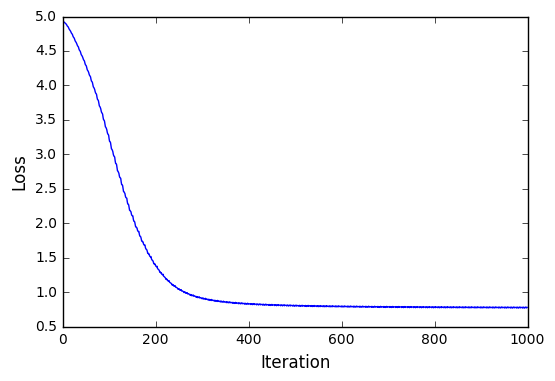

In [33]:
plt.plot(train_loss)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)

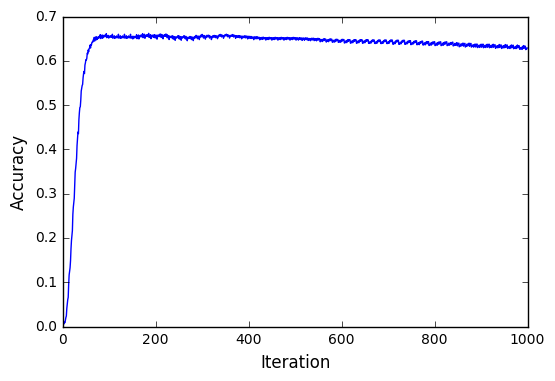

In [34]:
plt.plot(train_acc)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

### 順伝播（テスト時）

この演習の内容だけでは高度な文字予測ができるモデルは残念ながらできません。なので、ここで新しい文章をモデルにいれても意味のある文章はかえってきません。しかし、テスト時のコードをせっかく書いたので、最後にもとの文章を`forward_propagation_test`に入れて結果を確認してみましょう。

In [35]:
inputs = np.array([char2ix[ch] for ch in text])[:-1]
targets = np.array([char2ix[ch] for ch in text])[1:]
# to one-hot vector
eye = np.eye(len(char2ix))
inputs = eye[inputs]
targets = eye[targets]
inputs = np.expand_dims(inputs, 0)
targets = np.expand_dims(targets, 0)
Y_hat, loss = forward_propagation_test(inputs, targets, params)
Y_hat = np.array(list(Y_hat.values())).transpose(1,0,2)[:,1:]

acc = np.mean(np.argmax(Y_hat, axis=2)==np.argmax(targets, axis=2))
# ログをプリント
print('loss: {:.3f}, acc: {:.3f}'.format(np.mean(loss), np.mean(acc)))
txt =''.join(ix2char[ix] for ix in np.argmax(Y_hat, -1)[0])
print(txt)

loss: 0.924, acc: 0.000
ーーララルラュトまた。深層ニ習さは、多層ニ能ューラルネットワーラによっよの学習さ法をいる問し層ニ習さ場以上、多層ニ前、学層ニューラルネットワ、多所最適解や、配消失などの学術的など題によるた充分学習させられる、多能を芳し、なっした。深、った多年、多ンらワられよっよ層ニューラルネットワーラに学習さ学究や、多習さよ要なっ算機の学を向上、学よる、多ebの学達のよっよ練デーラ調達の学易化によるた充多分学習させられる機っによった。深の学果、多声・自像・自然言語を示しとはる。題によし、多の学法を示倒する。い性能を示し、多0年0年、によ及し、。深、ったっらに多層ニューラルネットワらい性能を示しるなの学論的などやは、んでいなっなし#
